**Experiementing with sequence filtering**

In [36]:
import numpy as np
import time
import pandas as pd
import pybloom_live as bloom
from Bio import SeqIO as seq
from Bio.Seq import Seq as Seqbuild
import os
import matplotlib.pyplot as plt

In [18]:
fasta = "C:/Users/jonah/School/ASI/bloom/GCF_002973605.1_ASM297360v1_genomic.fna"
# with open(fasta) as handle:
#     for record in list(seq.parse(handle,"fasta")):
#         print(record.id)


        
with open(fasta) as handle:
    records = list(seq.parse(handle,"fasta"))
        
tryme = records[:2]


with open("testy.fna", "w") as handle:
     seq.write(tryme, handle, "fasta")
    

In [28]:
bases=0
exons=0
with open(fasta) as genome_:
    for exon in seq.parse(genome_,"fasta"):
        bases+=len(exon.seq)
        exons+=1

print(bases)
print(exons)

import sys
print(sys.getsizeof("1"*20))

3606331
58
69


# to do: 

create.py file with bloom filter implemented 
    -eliminate check_read function call at every iteration
    -implement one hit pass for read
    -

implement input for read generators such that the number created is flexible

how would I change this to simulate aligning to a reference transcriptome? no need for splice awareness?

Using hash set is now the implementation to beat: perhaps creating compressed partial keys can improve hash time, but maybe not...this may also be overkill for bloom filter but could potentially be useful for storing huge numbers of long sequences as we do this with fewer bytes. 

things to test for sake of understanding runtimes:
    time to check set by key length
    time to check set by number of partials
    check how much one hit stop reduces runtime
    why certain combos of indices give us 50% accuracy and how to avoid this
    generally better understand best combos to try in order to make sure we don't systematically miss filter keys
    should be a function of partial size, read size, genome size, and check indices
    whether genome sampling can be used to reduce runtime while still attaining reasonable accuracy
    bloom filter effects on accuracy
    stacked bloom filter effects on accuracy
    whether we have enough memory to store a huge set filter...have only tested up to 30mm
    how much java implementation reduces runtime
   

these only have potential as alternative to stacked filter




In [8]:
def create_genome_exons2(total_size, exon_size):
    """
    create syntheic exon to map to
    
    input:total_size - length of genome
    exon_size- length of each exon
    output: matrix of exons -string row format
    """
    
    exome = np.random.randint(1,5,total_size)
    exome = exome.reshape(-1,exon_size)
    output = np.empty(exome.shape[0],dtype="object")
    
    for i in range(exome.shape[0]):
        row = exome[i]
        
        out_string = str()
        for j in range(len(row)):
            out_string+=(str(row[j]))
            
        output[i]=out_string
    
    return output

def create_transcriptome2(read_length, reads):
    """
    create synthetic transcriptome
    input-read length
    input- reads
    
    output- reads number of random transcripts of read_length
    this function is UNNECCESARY
    """
    
    transcriptome = np.random.randint(1,5,read_length*reads)
    transcriptome = transcriptome.reshape(-1,reads)
    output=np.empty(transcriptome.shape[0],dtype="object")
    
    for i in range(int(transcriptome.shape[0]/10)):
        
        row=transcriptome[i]
        outstring=str()
        
        for j in range(len(row)):
            outstring+=str(row[j])
            
        output[i]=outstring
            
    return output

def create_matched_transcriptome2(exome, read_length):
    """
    create synthetic matched reads
    
    input: exome (mxn) where n is read string length and m is number of array entries
    input: read_length: int
    
    output: matched reads potentially spanning exomes
    """
    
    bigstring = str()
    
    for i in exome[:int(len(exome)/100)]:
        bigstring+=i
        
    output = np.empty(len(bigstring)-read_length+1, dtype = "object")
    
    for i in range(len(bigstring)-read_length+1):
        transcript = bigstring[i:i+read_length]
        output[i] = transcript
        
    return output

def create_indels2(matched_transcriptome, indels_per_read):
    
    output = np.empty(len(matched_transcriptome), dtype="object")
    
    for i in range(len(matched_transcriptome)):
        
        new_read = matched_transcriptome[i]
        change_index = np.random.randint(0,len(new_read))
        
        if new_read[change_index]=="1":
            new_read = new_read[:change_index]+"4"+new_read[change_index+1:]
            
        else:
            insert=str(int(new_read[change_index])-1)
            new_read = new_read[:change_index]+insert+new_read[change_index+1:]
        
        output[i]=new_read
        
    return output

        
class read_object2():
    """
    create object to store the read we generate and its type...may expand class in the future to incorporate all
    the read types we need as well as method to iterate over them.
    """
    
    def __init__(self, variety, exome, read_length, indels_per_read = 1):
        
        self.group = variety
        self.indels_per_read = indels_per_read
        self.read_length = read_length
        
        #create indel read
        if self.group =="indel":
            self.reads = create_indels2(create_matched_transcriptome2(exome, read_length),self.indels_per_read)
        
        #create good transcriptome read   
        elif self.group =="good":
            self.reads = create_matched_transcriptome2(exome, read_length)
        
        #create bad transcriptome read
        elif self.group == "bad":
            self.reads = create_genome_exons2(int(len(exome)*len(exome[0])), read_length)

class filter_object2():
    """
    object to house the filter type and its attributes
    """
    
    def __init__ (self, exome, group_size, indices, set_filter = False, bloom =False, bloombits=1, fpr=0.01):
        self.exome = exome
        self.group_size = group_size
        self.indices = indices
        self.set_filter = set_filter
        self.bloom = bloom
        self.bloombits = bloombits
        self.fpr=fpr
    
    def generate_filter(self, verbose = False):
        """
        inputs:
        set_filter: implement filter using has set rather than array
        indices: generate the filter with partial keys beginning at these indices
        filter object: filter array to be populated with seen reads, can experient with augmenting existing filters later
        could have if/then stacked filter where we just keep grabbing larger partial keys (might be more efficient way
        to access reads and score them)

        output: filter with corresponding cells set to 1 for reads seen
        """
        
        #check to see if there are indices passed to filter obj
        #assumes that all exons are the same size
        if self.indices==False:
            self.indices = range(len(self.exome[0]))
           
            
        #use the set filter rather than array
        if self.set_filter:
            filter_array = set()
            
        if self.bloom == True:
            filter_array = bloom.BloomFilter(capacity = self.bloombits, error_rate = self.fpr)
            
        for i in range(len(self.exome)):

            exon = self.exome[i]
                
            #initialize variable to index array of start indices
            for j in self.indices:

                #verify that we don't go out of range
                if (j+self.group_size)>=len(exon):
                    break

                #add key to filter array
                filter_array.add(exon[j:j+self.group_size])

        self.filter_ = filter_array
        
        
    def check_read(self, read, check_indices, quick_check = False, quick_thresh = 1, verbose = False):
        """
        function checks to see if a read is present in the filter, utilizing self.filter_, group size and fwd_move
        
        read: transcriptome read to be mapped
        check_indices: array of start positions that we want to check
        quick_check: implement fast check to read...see if it passes threshold
        quick_thresh: threshold to be used for quick check
        
        outputs:number of size(group size) partial keys that appear in our filter
        """
        
        #test all combos if check indices are not stipulated
        if check_indices == False:
            check_indices = range(len(read)-self.group_size+1)

        #int to store number of partial reads that map
        hits = 0
            
        #set threshold if we are using quick check
        if quick_check:
            thresh = len(check_indices)*quick_thresh
                
            #grab partial keys for all given start keys
            for start_key in check_indices:

                if verbose:
                    print(f'key: {read[start_key:start_key+self.group_size]}')

                #check set filter for key
                if read[start_key:start_key+self.group_size] in self.filter_:
                    hits+=1
                    
                #break if we have reached necessary threshold
                if hits >thresh:
                     return len(check_indices)
        else:
            #grab partial keys for all given start keys
            for start_key in check_indices:

                if verbose:
                    print(f'key: {read[start_key:start_key+self.group_size]}')

                #check set filter for key
                if read[start_key:start_key+self.group_size] in self.filter_:
                    hits+=1
            
        return hits
    
    def one_hit_check (self, read, check_indices):
        """
        optimized check, breaks after one partial key hit that is in the filter, should be fastest
        way to check
        
        returns: boolean true if partial appears in filter, false if not
        """
        if check_indices == False:
            check_indices = range(len(read)-self.group_size+1)
            
        for start_key in check_indices:

            #check set filter for key
            if read[start_key:start_key+self.group_size] in self.filter_:
                        return True
        return False

       
def test_filters2(read_groups, exome, group_size_array, read_indices_array, genome_indices_array, thresh_array, quick_check = False, set_filter = False, bloom=True, fpr=0.01):
    """
    function to test filter params, going to begin by varying key size and forward moves
    
    inputs:
    reads: array of references to arrays holding reads
    exome: exome to create filter with 
    group_size_array: array holding group sizes to try
    genome_indices_array: array of genome indices from which to build partial keys to populate filter
    perc_thresh: percent threshold above which we want to count reads
    read_indices_array: read_indices to try...need to figure out how to pass rules thru array to subsample
    set_filter: whether to use hash set for filter vs array
    spacing: set to 0 for now
    quick_check: use the quick check method for check read
    
    output: dataframe with summary statistics for accuracy and time
    """
    
    #initialize output array variables
    gs = []
    gi = []
    ri = []
    good_percentage = []
    good_variance = []
    bad_percentage = []
    bad_variance = []
    good_thresh = []
    bad_thresh = []
    indel_thresh = []
    indel_percentage = []
    indel_variance = []
    generate_time_array=[]
    check_time_array=[]
    exome_shape =[]
    filter_full = []
    read_lengths = []
    num_reads=[]
    thresh_used = []
    

    #loop over grid
    for group_size in group_size_array:
        for genome_indices in genome_indices_array:
            for read_indices in read_indices_array:
                for perc_thresh in thresh_array:
                    
                    print("a")
                    gs.append(group_size)
                    gi.append(genome_indices)
                    ri.append(read_indices)
                    thresh_used.append(perc_thresh)
                    
                    #create filter
                    if genome_indices == False:
                        genome_read_size = len(exome[0])-group_size
                        
                    else:
                        genome_read_size = len(genome_indices)
                        
                    bloombits=group_size*genome_read_size*len(exome)/10
                    print(bloombits)
                    filter_obj = filter_object2(exome, group_size, genome_indices, set_filter = set_filter, bloom = bloom, bloombits=bloombits, fpr=fpr)
                
                    #time how long it takes to create 
                    generate_beg = time.time()
                    filter_obj.generate_filter()
                    generate_end = time.time()
                    print("generated filter")

                    #see how full the filter is
#                     if set_filter:
#                         filter_full_perc = len(filter_obj.filter_)/4**group_size
                    
#                     else:
#                         filter_full_perc= sum(filter_obj.filter_)/4**group_size
                  


                    #append create time to output array, grabbing percentage of array that is filled
                    generate_time_array.append(generate_end-generate_beg)

                    #TODO generate read indices according to protocol

                    #test all the transcriptome read objects and time them
                    check_beg = time.time()
                    for read_group in read_groups:

                        #creat placeholder variable to store read by read results
                        out_array = []
                        for row in range(read_group.reads.shape[0]):

                            #grab individual read and check it in the filter
                            read = read_group.reads[row]
                            out_array.append(filter_obj.check_read(read, read_indices,quick_check=quick_check,quick_thresh=perc_thresh))


                        #establish number of partial keys we tried
                        if read_indices == False:
                            pos = len(read_group.reads[0])-group_size+1

                        else:
                            pos = 0
                            for i in read_indices:
                                if i+group_size<len(read_group.reads[0]):
                                    pos+=1

                        #calculate ave percentage of hits
                        percentage_array = [i/pos for i in out_array]
                        prec = sum(percentage_array)/len(percentage_array)

                        #calcualte percentage of reads above thresh
                        thresh=0 
                        for i in percentage_array:
                            if i >=perc_thresh:
                                thresh+=1

                        thresh = thresh /len(percentage_array)


                        #calculate variance of num hits
                        var = np.var(out_array)


                        if read_group.group == "indel":
                            indel_percentage.append(prec)
                            indel_variance.append(var)
                            indel_thresh.append(thresh)

                        elif read_group.group == "good":
                            good_percentage.append(prec)
                            good_variance.append(var)
                            good_thresh.append(thresh)

                        else:
                            bad_percentage.append(prec)
                            bad_variance.append(var)
                            bad_thresh.append(thresh)

                    check_end = time.time()
                    
                    check_time_array.append(check_end-check_beg)
                    exome_shape.append(exome.shape[0])
                    filter_full.append(0)
                    read_lengths.append(len(read_groups[0].reads[0]))
                    num_reads.append(read_groups[0].reads.shape[0])


        out_df = pd.DataFrame({"Group Size":gs,"Genome Indices":gi,"Read Indices":ri, "Good Percentage":good_percentage,
                              "Bad Percentage":bad_percentage, "Indel Percentage":indel_percentage, "Good Variance":good_variance,
                              "Bad Variance":bad_variance, "Indel Variance":indel_variance, "Good Thresh":good_thresh,
                              "Bad Thresh":bad_thresh, "Indel Thresh": indel_thresh, "Create Time": generate_time_array,
                              "Check Time": check_time_array,"Exome Size":exome_shape, "Read Lengths": read_lengths, "Num Reads":num_reads, 
                              "Filter Full Percentage":filter_full, "Threshold Used":thresh_used})
        
    return out_df, filter_obj  

In [10]:
f = bloom.BloomFilter(capacity = 100000000, error_rate = 0.1)
f.add("gact")
"gact" in f

True

In [9]:
a= time.time()
exome2 = create_genome_exons2 (int(3e7),int(3e5))
#bad_transcriptome = create_transcriptome(80,20)
#good_transcriptome = create_matched_transcriptome(exome, 20)
#indels = create_indels(good_transcriptome,1)
print(1)
bad2 = read_object2("bad", exome2, 100)
print(2)
good2 = read_object2("good",exome2, 100)
print(3)
indel2 = read_object2("indel",exome2, 100)
b=time.time()

print(f"bad2 {len(bad2.reads), len(bad2.reads[0])}")
print(f"good2 {len(good2.reads),len(good2.reads[0])}")
print(f"indel2 {len(indel2.reads),len(indel2.reads[0])}")
print(f"total {len(bad2.reads)+len(good2.reads)+len(indel2.reads)}")
print(f"exome length {len(exome2)}")
print(f"exon length {len(exome2[0])}")
print(f"time to generate: {b-a}")

1
2
3
bad2 (300000, 100)
good2 (299901, 100)
indel2 (299901, 100)
total 899802
exome length 100
exon length 300000
time to generate: 32.60583162307739


In [33]:
seq.write(a,)

SeqRecord(seq=Seq('CTTATGCACCTCATCGTCTTTCGACTTTTTCTTGTCCAATACAACACCCACAAA...TTC'), id='NZ_NIGF01000001.1', name='NZ_NIGF01000001.1', description='NZ_NIGF01000001.1 Abditibacterium utsteinense strain LMG 29911 Contig001, whole genome shotgun sequence', dbxrefs=[])

In [38]:
with open("C:/Users/jonah/School/ASI/bloom/GCF_002973605.1_ASM297360v1_genomic.fna") as handle:
    a= list(seq.parse(handle,"fasta"))[0]

a

def seq_to_read (seq, generic):
    """
    convert synthetic sequence to fasta style read
    """
    
    generic.seq=Seqbuild(seq)
    
    return generic

seq_to_read(Seqbuild("ACGTACG"),a)

SeqRecord(seq=Seq('ACGTACG'), id='NZ_NIGF01000001.1', name='NZ_NIGF01000001.1', description='NZ_NIGF01000001.1 Abditibacterium utsteinense strain LMG 29911 Contig001, whole genome shotgun sequence', dbxrefs=[])

In [43]:
with open("C:\\Users\\jonah\\School\\ASI\\bloom\\syntheticData\\indel.fasta", "w") as genome:
    for i in indel2.reads:
        seq.write(seq_to_read(i,a), genome, "fasta")

In [47]:
threes=list()
twos=list()
fours = list()
fives = list()
sixes = list()
sevens = list()
twos2=list()
twosfin=list()


i=0
for i in range(int(3e5)):
    if i%2==0:
        twos.append(i)
        twos2.append(i+1)
        
    if i%3==0:
        threes.append(i)
        
    if i%4==0:
        fours.append(i)
        
    if i%5==0:
        fives.append(i)
        
    if i%6==0:
        sixes.append(i)
    if i%7==0:
        sevens.append(i)

for i in range(len(twos2)):
    if i%2==0:
        twosfin.append(twos2[i])
    else:
        twosfin.append(twos[i])
        
genome_indices = [False]
read_indices = [[ 0,  1, 17, 18]]
partial_key_size = [16]
thresholds=[0.01]

a, b=test_filters2([bad2, good2, indel2],exome2, partial_key_size, read_indices ,genome_indices, thresholds,quick_check=True, set_filter = True, bloom=False, fpr=0.1)
#a.to_csv("genome_index_300mm_5.30.csv")
a

a
47997440.0
generated filter


,Group Size,Genome Indices,Read Indices,Good Percentage,Bad Percentage,Indel Percentage,Good Variance,Bad Variance,Indel Variance,Good Thresh,Bad Thresh,Indel Thresh,Create Time,Check Time,Exome Size,Read Lengths,Num Reads,Filter Full Percentage,Threshold Used
0,16,False,"[0, 1, 17, 18]",1.0,0.024267,1.0,0.0,0.378845,0.0,1.0,0.024267,1.0,14.291483,1.099352,100,100,300000,0,0.01


In [ ]:

a, b=test_filters2([bad2, good2, indel2],exome2, partial_key_size, read_indices ,genome_indices, thresholds,quick_check=True, set_filter = False, bloom=True, fpr=0.1)

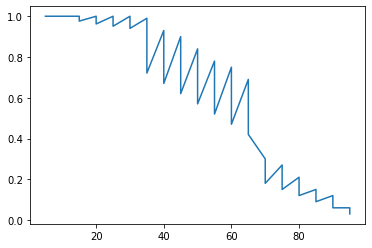

In [27]:
# x= [100/i for i in [1,2,3,4,5,6,7]]

x=a["Group Size"]
y=a["Good Thresh"]

plt.plot(x,y)
plt.show()

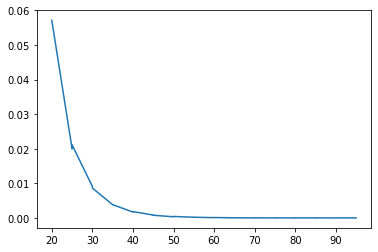

In [30]:
x=a["Group Size"][7:]
y=a["Bad Thresh"][7:]

plt.plot(x,y)
plt.show()

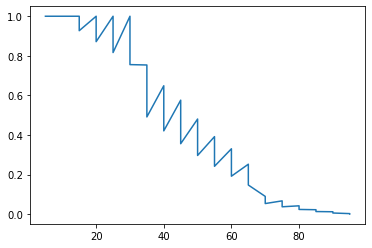

In [31]:
x=a["Group Size"]
y=a["Indel Thresh"]

plt.plot(x,y)
plt.show()

In [85]:
3e9/4**10

2861.02294921875

In [90]:
def estimate_perc_full(size,key_length, ex_length):
    
    samps = size-(key_length*size/ex_length)
    expected_unique=(1-(1-1/samps)**(4**key_length))*samps
    return expected_unique/4**key_length

def estimate_mem_req(exome_mem, size, key_length, ex_length):
    
    perc_full=estimate_perc_full(size, key_length, ex_length)
    
    if perc_full>1:
        return (4**key_length)/size*exome_mem
        
    return perc_full*exome_mem*key_length*(4**key_length/size)

a
print(estimate_perc_full(3e7,15,3e5))
print(estimate_mem_req(1,4e9,18,150))
print(estimate_perc_full(4e9,18,150)*4**18)


0.027938280254602422
15.839999947373023
3519999988.305116


In [17]:
4**10

1048576

In [12]:
def estimate_perc_full_2(bases,key_length, num_ex,sparsity_factor):
    
    
    samps = ((bases/num_ex)-key_length)*num_ex/sparsity_factor
    expected_unique=(1-(1-1/samps)**(4**key_length))*samps
    return expected_unique/4**key_length

def estimate_perc_full_3(bases,key_length, num_ex,sparsity_factor):
    
    
    samps = ((bases/num_ex)-key_length)*num_ex/sparsity_factor
    expected_unique=(1-(1-1/samps)**(4**key_length))*samps
    return expected_unique/4**key_length

print(estimate_perc_full_2(3e7,20,3e7/3e5,1))

2.72830220637843e-05


In [35]:
def choose_genome_sparsity(genome_filesize, read_filesize, read_length, key_size, average_exon_size, flex_factor, num_files):
    """
    function to choose genome indices and read indices to optimize for runtime
    genome and read filesizes only need to be in the same units
    """
    
    if key_size>=average_exon_size or key_size >= read_length:
        return("err: key size is too large")
    
    num = genome_filesize*(1-(key_size/average_exon_size))
    denom = (read_filesize/read_length)*flex_factor*num_files
    
    return int((num/denom)**0.5)

In [39]:
choose_genome_sparsity(3,9,100,30,100,2,1)

3

In [10]:
a=[]
seen_key = set()
seen_slot = set()

for i in range(10000):
    
    key=(str(np.random.randint(1,5)*1000000+np.random.randint(1,5)*100000+np.random.randint(1,5)*10000+np.random.randint(1,5)*1000+np.random.randint(1,5)*100+np.random.randint(1,5)*10+np.random.randint(1,5)))
    
    if key not in seen_key:
        seen_key.add(key)
        
        slot=(int(key[0]))+int(key[1])*4+int(key[2])*16+int(key[3])*64+int(key[4])*256+int(key[5])*1024+int(key[6])*4096
        if slot in seen_slot:
            print(f"bummer: {key,slot}")
            
        else:
            seen_slot.add(slot)

            
print(max(seen_slot), min(seen_slot))


21844 5461


In [ ]:
a=[]
seen_key = set()
seen_slot = set()

for i in range(10000):
    
    key=(str(np.random.randint(0,4)*100+np.random.randint(0,4)*10+np.random.randint(0,4)))
    
    if key not in seen_key:
        seen_key.add(key)
        
        slot=(int(key[0])*4)+int(key[1])*16+int(key[2])+10
        if slot in seen_slot:
            print(f"bummer: {key,slot}")
            
        else:
            seen_slot.add(slot)
            
print("done")

In [ ]:
##Create FASTA files here



# Old Implementation: read arrays rather than strings, seems 5x slower

In [ ]:
def create_genome_exons(total_size, exon_size):
    """
    create syntheic exon to map to
    
    input:total_size - length of genome
    exon_size- length of each exon
    output: matrix of exons
    """
    
    exome = np.random.randint(1,5,total_size)
    exome = exome.reshape(-1,exon_size)
    
    return exome

def create_transcriptome(read_length, reads):
    """
    create synthetic transcriptome
    input-read length
    input- reads
    
    output- reads number of random transcripts of read_length
    """
    
    transcriptome = np.random.randint(1,5,read_length*reads)
    transcriptome = transcriptome.reshape(-1,reads)
    
    return transcriptome

def create_matched_transcriptome(exome, read_length):
    """
    create synthetic matched reads
    
    input: exome (mxn)
    input: read_length: int
    """
    
    exome=exome.flatten()
    out_matrix = np.zeros([int(len(exome)-read_length)+1, read_length])
    
    for i in range(len(exome)-read_length+1):
        transcript = exome[i:i+read_length]
        out_matrix[i]+=transcript
        
    return out_matrix

def create_indels(matched_transcriptome, indels_per_read):
    
    outmatrix = np.zeros([matched_transcriptome.shape[0],matched_transcriptome.shape[1]])
    
    for row in range(matched_transcriptome.shape[0]):
        
        new_read = matched_transcriptome[row]
        
        change_index = np.random.randint(0,len(new_read))
        
        if new_read[change_index]==1:
            new_read[change_index]=4
            
        else:
            new_read[change_index]-=1
            
        outmatrix[row]+=new_read
        
    return outmatrix

        
class read_object():
    """
    create object to store the read we generate and its type...may expand class in the future to incorporate all
    the read types we need as well as method to iterate over them.
    """
    
    def __init__(self, variety, exome, read_length, indels_per_read = 1):
        
        self.group = variety
        self.indels_per_read = indels_per_read
        
        #create indel read
        if self.group =="indel":
            self.reads = create_indels(create_matched_transcriptome(exome, read_length),self.indels_per_read)
        
        #create good transcriptome read   
        elif self.group =="good":
            self.reads = create_matched_transcriptome(exome, read_length)
        
        #create bad transcriptome read
        elif self.group == "bad":
            self.reads = create_transcriptome (exome.shape[0]*read_length, read_length)
            
class filter_object():
    """
    object to house the filter type and its attributes
    """
    
    def __init__ (self, exome, group_size, fwd_move, spacing=0):
        self.exome = exome
        self.group_size = group_size
        self.fwd_move = fwd_move
        self.spacing = spacing
    
    def generate_filter(self, verbose = False):
        """
        inputs:
        exome: exome matrix form
        group_size: number of bases in partial key to populate filter with
        spacing: number of bases to skip when generating key
        fwd_move: how many bp to move forward following partial key creation
        filter object: filter array to be populated with seen reads, can experient with augmenting existing filters later
        could have if/then stacked filter where we just keep grabbing larger partial keys (might be more efficient way
        to access reads and score them)

        output: filter with corresponding cells set to 1 for reads seen
        """

        #generate proper size for array (can do this more compactly)
        base=0
        for i in range(self.group_size):
            base+=(4*10**i)

        if verbose:
            print("base size: "+str(base))


        #generate filter
        filter_array = np.zeros(base+1)

        #grab each exon and create keys to populate filter
        for row in range(self.exome.shape[0]):

            exon = self.exome[row]

            if verbose:
                print(f'len exon: {len(exon)}')

            if self.spacing >0:
                #set this aside for now
                pass

            else:
                start_key=0

                #grab partial keys until we reach the end of the exon
                while (start_key+self.group_size)<=len(exon):

                    if verbose:
                        print(f'key: {exon[start_key:start_key+self.group_size]}')

                    #generate key
                    key=0
                    mult=1
                    for i in range(self.group_size):
                        key+=exon[start_key+i]*mult
                        mult*=10
                      
                    #add key to filter array
                    filter_array[key]=1

                    #move the start of next partial key according to fwd move input
                    start_key+=self.fwd_move

                    if verbose:

                        print(f'new start key{start_key}')

        self.filter_ = filter_array
        
        
    def check_read(self, read, check_indices, verbose = False):
        """
        function checks to see if a read is present in the filter, utilizing self.filter_, group size and fwd_move
        
        read: transcriptome read to be mapped
        check_indices: array of start positions that we want to check
        
        outputs:number of size(group size) partial keys that appear in our filter
        """
        #test all combos if check indices are not stipulated
        if check_indices == False:
            check_indices = range(len(read)-self.group_size+1)
            
        #int to store number of partial reads that map
        hits = 0
        
        #catch this later
        if self.spacing >0:
            pass
        
        #grab partial keys for all given start keys
        for start_key in check_indices:

            if verbose:
                print(f'key: {read[start_key:start_key+self.group_size]}')

            #generate key
            key=0
            mult=1
            for i in range(self.group_size):
                   
                key+=read[start_key+i]*mult
                mult*=10

            #check filter_ for key
            hits += self.filter_[int(key)]   

            #move the start of next partial key according to fwd move input
            start_key+=self.fwd_move

            if verbose:
                print(f'new start key{start_key}')
                    
        return hits

       
def test_filters(read_groups, exome, group_size_array, read_indices_array, fwd_move_array, thresh_array, spacing=0):
    """
    function to test filter params, going to begin by varying key size and forward moves
    
    inputs:
    reads: array of references to arrays holding reads
    exome: exome to create filter with 
    group_size_array: array holding group sizes to try
    fwd_move_array: array holding fwd moves to try
    perc_thresh: percent threshold above which we want to count reads
    read_indices_array: read_indices to try...need to figure out how to pass rules thru array to subsample
    spacing: set to 0 for now
    
    output: dataframe with summary statistics for accuracy and time
    """
    
    #initialize output array variables
    gs = []
    fwd = []
    ri = []
    good_percentage = []
    good_variance = []
    bad_percentage = []
    bad_variance = []
    good_thresh = []
    bad_thresh = []
    indel_thresh = []
    indel_percentage = []
    indel_variance = []
    generate_time_array=[]
    check_time_array=[]
    exome_shape =[]
    filter_full = []
    read_lengths = []
    num_reads=[]
    
    #loop over grid
    for group_size in group_size_array:
        for fwd_move in fwd_move_array:
            for read_indices in read_indices_array:
                for perc_thresh in thresh_array:
                    gs.append(group_size)
                    fwd.append(fwd_move)
                    ri.append(read_indices)

                    #create filter
                    filter_obj = filter_object(exome, group_size, fwd_move)


                    #time how long it takes to create 
                    generate_beg = time.time()
                    filter_obj.generate_filter()
                    generate_end = time.time()

                    #see how full the filter is
                    filter_full_perc= sum(filter_obj.filter_)/4**group_size



                    #append create time to output array, grabbing percentage of array that is filled
                    generate_time_array.append(generate_end-generate_beg)

                    #TODO generate read indices according to protocol

                    #test all the transcriptome read objects and time them
                    check_beg = time.time()
                    for read_group in read_groups:

                        #creat placeholder variable to store read by read results
                        out_array = []
                        for row in range(read_group.reads.shape[0]):

                            #grab individual read and check it in the filter
                            read = read_group.reads[row]
                            out_array.append(filter_obj.check_read(read, read_indices))

                            if out_array[-1]<1:
                                print(f"hey!-----{row,read}")

                        #establish number of partial keys we tried
                        if read_indices == False:
                            pos = len(read_group.reads[0])-group_size+1

                        else:
                            pos = len(read_indices)

                        #calculate ave percentage of hits
                        percentage_array = [i/pos for i in out_array]
                        prec = sum(percentage_array)/len(percentage_array)

                        #calcualte percentage of reads above thresh
                        thresh=0 
                        for i in percentage_array:
                            if i >=perc_thresh:
                                thresh+=1

                        thresh = thresh /len(percentage_array)


                        #calculate variance of num hits
                        var = np.var(out_array)


                        if read_group.group == "indel":
                            indel_percentage.append(prec)
                            indel_variance.append(var)
                            indel_thresh.append(thresh)

                        elif read_group.group == "good":
                            good_percentage.append(prec)
                            good_variance.append(var)
                            good_thresh.append(thresh)

                        else:
                            bad_percentage.append(prec)
                            bad_variance.append(var)
                            bad_thresh.append(thresh)

                    check_end = time.time()
                    check_time_array.append(check_end-check_beg)
                    exome_shape.append(exome.shape[0])
                    filter_full.append(filter_full_perc)
                    read_lengths.append(read_groups[0].reads.shape[1])
                    num_reads.append(read_groups[0].reads.shape[0])


        out_df = pd.DataFrame({"Group Size":gs,"Fwd Move":fwd,"Read Indices":ri, "Good Percentage":good_percentage,
                              "Bad Percentage":bad_percentage, "Indel Percentage":indel_percentage, "Good Variance":good_variance,
                              "Bad Variance":bad_variance, "Indel Variance":indel_variance, "Good Thresh":good_thresh,
                              "Bad Thresh":bad_thresh, "Indel Thresh": indel_thresh, "Create Time": generate_time_array,
                              "Check Time": check_time_array,"Exome Size":exome_shape, "Read Lengths": read_lengths, "Num Reads":num_reads, 
                              "Filter Full Percentage":filter_full})
        
    return out_df, filter_obj      